In [1]:
from functools import partial
import numpy as np
from io import StringIO
import matplotlib.pyplot as plt
import cv2

import sys
sys.path.append('/home/oscar_palfelt/MSc_thesis/ompl/py-bindings')
from ompl import base as ob
from ompl import control as oc
from ompl import geometric as og

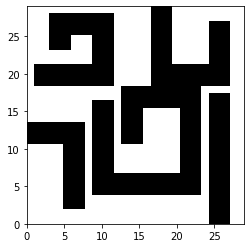

In [2]:
# Load obstacle data
filename = '/home/oscar_palfelt/MSc_thesis/EECS_Degree_Project/motion_planning/data_generation/map_difficult.png'
mapImg = cv2.imread(filename, 0)
blurImg = cv2.blur(mapImg, ksize=(3,3))

occGrid = np.clip(mapImg, 0, 1)
inflatedGrid = np.floor(blurImg / 255)
gridSize = occGrid.shape[0]

plt.imshow(inflatedGrid, extent=[0, gridSize-1, 0, gridSize-1], cmap='gray')
plt.show()

In [3]:
# define planning problem

def isStateValid(spaceInformation, state):
    # perform collision checking or check if other constraints are
    # satisfied
    u = int(np.floor(state.getX() * occGrid.shape[1])) # right pointing image axis
    v = int(np.floor(occGrid.shape[0] * (1 - state.getY()))) # down pointing image axis

    if spaceInformation.satisfiesBounds(state):
        return occGrid[v,u] > 0


def problemDef():
    # construct the state space we are planning in
    space = ob.DubinsStateSpace(turningRadius=0.05)
    #space = ob.SE2StateSpace()

    # set the bounds for the R^2 part of SE(2)
    bounds = ob.RealVectorBounds(2)
    bounds.setLow(0.001)
    bounds.setHigh(0.999)
    space.setBounds(bounds)

    # define a simple setup class
    ss = og.SimpleSetup(space)
    ss.setStateValidityChecker(ob.StateValidityCheckerFn( \
        partial(isStateValid, ss.getSpaceInformation())))

    si = ss.getSpaceInformation()
    planner = og.RRTstar(si)
    ss.setPlanner(planner)

    return ss


def plan(planObj, initState, goalState):

    space = ob.DubinsStateSpace(turningRadius=0.05)
    #space = ob.SE2StateSpace()
    
    start = ob.State(space)
    start().setX(initState[0])
    start().setY(initState[1])
    start().setYaw(initState[2])

    goal = ob.State(space)
    goal().setX(goalState[0])
    goal().setY(goalState[1])
    goal().setYaw(goalState[2])
    
    planObj.setStartAndGoalStates(start, goal, 0.1)

    timeTerminationCondition = ob.timedPlannerTerminationCondition(4.0)
    costTerminationCondition = ob.CostConvergenceTerminationCondition(planObj.getProblemDefinition(), epsilon=0.5)
    orTerminationCondition = ob.plannerOrTerminationCondition(costTerminationCondition, timeTerminationCondition)

    planObj.solve(orTerminationCondition)

In [6]:
# generate planning data, car scenario

nData = 10 # number of plans to generate

minDistThreshold = 0.5 # minimum distance threshold betwen start/goal

trajSamples = np.zeros(shape=(1, 4)) # x, y, xdot, ydot
newInitData = np.zeros(shape=(1, 4)) # x, y, xdot, ydot
newGoalData = np.zeros(shape=(1, 4))

planObj = problemDef()

plotPaths = False
i = 0 
nPlans = 0 # number of completed plans
while nPlans < nData:

    start = np.array([0, 0, 0]) # x, y, yaw
    goal  = np.copy(start)
    ux = 0; vx = 0; uy = 0; vy = 0
    
    while True:
        start = np.array([np.random.uniform(low=0.001, high=0.999), np.random.uniform(low=0.001, high=0.999), np.random.uniform(low=-np.pi, high=np.pi)])
        goal  = np.array([np.random.uniform(low=0.001, high=0.999), np.random.uniform(low=0.001, high=0.999), np.random.uniform(low=-np.pi, high=np.pi)])
        ux = int(np.floor(start[0] * gridSize)) # right pointing image axis
        vx = int(np.floor(gridSize * (1 - start[1]))) # down pointing image axis
        uy = int(np.floor(goal[0] * gridSize)) # right pointing image axis
        vy = int(np.floor(gridSize * (1 - goal[1]))) # down pointing image axis
        if np.linalg.norm(start[:2] - goal[:2]) > minDistThreshold and inflatedGrid[vx,ux] > 0 and inflatedGrid[vy,uy] > 0:
            break

    plan(planObj, start, goal)

    if planObj.getProblemDefinition().hasExactSolution():

        sol = np.loadtxt(StringIO(planObj.getSolutionPath().printAsMatrix()))
        nSamples = sol.shape[0]

        xdot = np.cos(sol[:,2]).reshape((nSamples,1))
        ydot = np.sin(sol[:,2]).reshape((nSamples,1))
        trajSamples = np.vstack((trajSamples, np.hstack((sol[:, 0:2], xdot, ydot)))) # x, y, xdot, ydot
        newInitData = np.vstack((newInitData, np.tile(np.append(start[0:2], [np.cos(start[-1]), np.sin(start[-1])]), reps=(nSamples, 1)))) # x, y, yaw, xdot, ydot
        newGoalData = np.vstack((newGoalData, np.tile(np.append(goal[0:2], [np.cos(goal[-1]), np.sin(goal[-1])]), reps=(nSamples, 1)))) # x, y, yaw, xdot, ydot
        
        if plotPaths:
            fig, ax = plt.subplots()
            ax.imshow(occGrid, extent=[0, gridSize-1, 0, gridSize-1], cmap='gray')
            ax.scatter(start[0] * (gridSize - 1), start[1] * (gridSize - 1), color="red", s=250, edgecolors='black')
            ax.scatter(goal[0] * (gridSize - 1), goal[1] * (gridSize - 1), color="blue", s=250, edgecolors='black')
            ax.quiver(sol[:, 0] * (gridSize - 1), sol[:, 1] * (gridSize - 1), np.cos(sol[:,2]), np.sin(sol[:,2]), color="purple", scale=8.0, width=0.015, alpha=0.9)
            plt.show()

        nPlans += 1
        if nPlans % 100 == 0:
            newData = np.concatenate((trajSamples, newInitData, newGoalData), axis=1)[1:]
            np.savetxt('/home/oscar_palfelt/MSc_thesis/EECS_Degree_Project/motion_planning/data/pathDataDifficult_i' + str(i), newData, delimiter=',', fmt='%1.6f')
  
    planObj.clear()
    i += 1  

    #ob.ProblemDefinition.getSolution

newData = np.concatenate((trajSamples, newInitData, newGoalData), axis=1)[1:]
np.savetxt('/home/oscar_palfelt/MSc_thesis/EECS_Degree_Project/motion_planning/data/pathDataDifficult', newData, delimiter=',', fmt='%1.6f')


Debug:   RRTstar: Planner range detected to be 0.596436
Info:    RRTstar: No optimization objective specified. Defaulting to optimizing path length for the allowed planning time.
Info:    RRTstar: Started planning with 1 states. Seeking a solution better than 0.00000.
Info:    RRTstar: Initial k-nearest value of 45
Info:    RRTstar: Found an initial solution with a cost of 1.00 in 737 iterations (93 vertices in the graph)


         at line 101 in /home/oscar_palfelt/MSc_thesis/ompl/src/ompl/geometric/planners/rrt/src/RRTstar.cpp


Info:    RRTstar: Created 746 new states. Checked 220072 rewire options. 2 goal states in tree. Final solution cost 0.923
Info:    Solution found in 4.010018 seconds
Info:    RRTstar: Started planning with 1 states. Seeking a solution better than 0.00000.
Info:    RRTstar: Initial k-nearest value of 45


         at line 101 in /home/oscar_palfelt/MSc_thesis/ompl/src/ompl/geometric/planners/rrt/src/RRTstar.cpp


Info:    ProblemDefinition: Adding approximate solution from planner RRTstar
Info:    RRTstar: Created 791 new states. Checked 239173 rewire options. 0 goal states in tree. Final solution cost inf
Info:    Solution found in 4.004612 seconds
Info:    RRTstar: Started planning with 1 states. Seeking a solution better than 0.00000.
Info:    RRTstar: Initial k-nearest value of 45


         at line 101 in /home/oscar_palfelt/MSc_thesis/ompl/src/ompl/geometric/planners/rrt/src/RRTstar.cpp


Info:    RRTstar: Found an initial solution with a cost of 1.23 in 1279 iterations (239 vertices in the graph)
Info:    RRTstar: Created 789 new states. Checked 238321 rewire options. 1 goal states in tree. Final solution cost 1.229
Info:    Solution found in 4.001526 seconds
Info:    RRTstar: Started planning with 1 states. Seeking a solution better than 0.00000.
Info:    RRTstar: Initial k-nearest value of 45


         at line 101 in /home/oscar_palfelt/MSc_thesis/ompl/src/ompl/geometric/planners/rrt/src/RRTstar.cpp


Info:    RRTstar: Found an initial solution with a cost of 1.29 in 62972 iterations (52 vertices in the graph)
Info:    RRTstar: Created 566 new states. Checked 145519 rewire options. 2 goal states in tree. Final solution cost 0.966
Info:    Solution found in 4.002665 seconds
Info:    RRTstar: Started planning with 1 states. Seeking a solution better than 0.00000.
Info:    RRTstar: Initial k-nearest value of 45


         at line 101 in /home/oscar_palfelt/MSc_thesis/ompl/src/ompl/geometric/planners/rrt/src/RRTstar.cpp


Info:    ProblemDefinition: Adding approximate solution from planner RRTstar
Info:    RRTstar: Created 757 new states. Checked 224725 rewire options. 0 goal states in tree. Final solution cost inf
Info:    Solution found in 4.001189 seconds
Info:    RRTstar: Started planning with 1 states. Seeking a solution better than 0.00000.
Info:    RRTstar: Initial k-nearest value of 45
Info:    RRTstar: Found an initial solution with a cost of 1.86 in 273 iterations (34 vertices in the graph)


         at line 101 in /home/oscar_palfelt/MSc_thesis/ompl/src/ompl/geometric/planners/rrt/src/RRTstar.cpp


Info:    RRTstar: Created 768 new states. Checked 229389 rewire options. 5 goal states in tree. Final solution cost 1.256
Info:    Solution found in 4.001724 seconds
Info:    RRTstar: Started planning with 1 states. Seeking a solution better than 0.00000.
Info:    RRTstar: Initial k-nearest value of 45


         at line 101 in /home/oscar_palfelt/MSc_thesis/ompl/src/ompl/geometric/planners/rrt/src/RRTstar.cpp


Info:    RRTstar: Found an initial solution with a cost of 1.32 in 2271 iterations (432 vertices in the graph)
Info:    RRTstar: Created 768 new states. Checked 229389 rewire options. 1 goal states in tree. Final solution cost 1.185
Info:    Solution found in 4.008483 seconds
Info:    RRTstar: Started planning with 1 states. Seeking a solution better than 0.00000.
Info:    RRTstar: Initial k-nearest value of 45


         at line 101 in /home/oscar_palfelt/MSc_thesis/ompl/src/ompl/geometric/planners/rrt/src/RRTstar.cpp


Info:    RRTstar: Found an initial solution with a cost of 1.76 in 1032 iterations (179 vertices in the graph)
Info:    RRTstar: Created 770 new states. Checked 230238 rewire options. 1 goal states in tree. Final solution cost 1.175
Info:    Solution found in 4.012109 seconds
Info:    RRTstar: Started planning with 1 states. Seeking a solution better than 0.00000.
Info:    RRTstar: Initial k-nearest value of 45
Info:    RRTstar: Found an initial solution with a cost of 1.66 in 101 iterations (20 vertices in the graph)


         at line 101 in /home/oscar_palfelt/MSc_thesis/ompl/src/ompl/geometric/planners/rrt/src/RRTstar.cpp


Info:    RRTstar: Created 756 new states. Checked 224302 rewire options. 1 goal states in tree. Final solution cost 1.348
Info:    Solution found in 4.001131 seconds
Info:    RRTstar: Started planning with 1 states. Seeking a solution better than 0.00000.
Info:    RRTstar: Initial k-nearest value of 45


         at line 101 in /home/oscar_palfelt/MSc_thesis/ompl/src/ompl/geometric/planners/rrt/src/RRTstar.cpp


Info:    ProblemDefinition: Adding approximate solution from planner RRTstar
Info:    RRTstar: Created 785 new states. Checked 236617 rewire options. 0 goal states in tree. Final solution cost inf
Info:    Solution found in 4.000019 seconds
Info:    RRTstar: Started planning with 1 states. Seeking a solution better than 0.00000.
Info:    RRTstar: Initial k-nearest value of 45


         at line 101 in /home/oscar_palfelt/MSc_thesis/ompl/src/ompl/geometric/planners/rrt/src/RRTstar.cpp


Info:    RRTstar: Found an initial solution with a cost of 1.86 in 3210 iterations (320 vertices in the graph)
Info:    RRTstar: Created 736 new states. Checked 215851 rewire options. 1 goal states in tree. Final solution cost 1.803
Info:    Solution found in 4.001987 seconds
Info:    RRTstar: Started planning with 1 states. Seeking a solution better than 0.00000.
Info:    RRTstar: Initial k-nearest value of 45
Info:    RRTstar: Found an initial solution with a cost of 1.39 in 85 iterations (12 vertices in the graph)


         at line 101 in /home/oscar_palfelt/MSc_thesis/ompl/src/ompl/geometric/planners/rrt/src/RRTstar.cpp


Info:    RRTstar: Created 761 new states. Checked 226421 rewire options. 1 goal states in tree. Final solution cost 0.912
Info:    Solution found in 4.007508 seconds
Info:    RRTstar: Started planning with 1 states. Seeking a solution better than 0.00000.
Info:    RRTstar: Initial k-nearest value of 45
Info:    RRTstar: Found an initial solution with a cost of 1.39 in 203 iterations (16 vertices in the graph)


         at line 101 in /home/oscar_palfelt/MSc_thesis/ompl/src/ompl/geometric/planners/rrt/src/RRTstar.cpp


Info:    RRTstar: Created 785 new states. Checked 236617 rewire options. 2 goal states in tree. Final solution cost 1.127
Info:    Solution found in 4.001646 seconds
